In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

time: 309 µs (started: 2022-01-08 04:44:45 +00:00)


In [2]:
# https://github.com/ninja3697/Stocks-Price-Prediction-using-Multivariate-Analysis/blob/master/Multivatiate-LSTM/.ipynb_checkpoints/Multivariate-3-LSTM-Copy1-checkpoint.ipynb
# Importing dependencies

import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.layers import Dropout
from sklearn.model_selection import KFold
from math import sqrt
import datetime as dt
plt.style.use('ggplot')

time: 1.64 s (started: 2022-01-08 04:44:45 +00:00)


In [3]:
# %cd '/content/drive/Shareddrives/myShareDrive'

time: 293 µs (started: 2022-01-08 04:44:46 +00:00)


In [4]:
#data = pd.read_csv('./dataset/FS_sp500_Value.csv', parse_dates=['Date'], infer_datetime_format=True)
data = pd.read_csv('./dataset/FS_sp500_Value.csv', parse_dates=['Date'], infer_datetime_format=True, index_col=0)

time: 1.45 s (started: 2022-01-08 04:44:46 +00:00)


In [5]:
#data_APA = data.query('Ticker == "APA"').drop(['Unnamed: 0', 'Ticker'], axis=1)
data_APA = data.query('Ticker == "APA"').drop(['Ticker'], axis=1)

time: 18.3 ms (started: 2022-01-08 04:44:48 +00:00)


In [6]:
# Using set_index() method on 'Name' column
data_APA = data_APA.set_index(data_APA['Date'])

time: 617 µs (started: 2022-01-08 04:44:48 +00:00)


In [7]:
# Correlation matrix
data_APA.corr()['Close']

High         0.999711
Low          0.999743
Open         0.999399
Close        1.000000
Volume      -0.479447
Adj Close    0.999291
Name: Close, dtype: float64

time: 3.23 ms (started: 2022-01-08 04:44:48 +00:00)


In [8]:
#data_APA = data_APA.drop(['Volume'], axis=1)

time: 280 µs (started: 2022-01-08 04:44:48 +00:00)


In [9]:
#print(data_APA.describe().Volume) 

time: 283 µs (started: 2022-01-08 04:44:48 +00:00)


In [10]:
data_APA.drop(data_APA[data_APA['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

time: 1.33 ms (started: 2022-01-08 04:44:48 +00:00)


In [11]:
data_APA.shape

(2997, 7)

time: 1.03 ms (started: 2022-01-08 04:44:48 +00:00)


In [12]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

time: 401 µs (started: 2022-01-08 04:44:48 +00:00)


In [13]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs,loss,activation):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, activation = activation, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(0.2))
    # Adding LSTM layers and some Dropout regularisation
    for i in range(len(hl)-1):        
      model.add(LSTM(hl[i], activation = activation,return_sequences = True))
      #model.add(Dropout(0.2))
    model.add(LSTM(hl[-1],activation = activation))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))

    # Compiling the RNN
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= lr), loss = loss)
    
    model.summary()
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

time: 1.02 ms (started: 2022-01-08 04:44:48 +00:00)


In [14]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

time: 553 µs (started: 2022-01-08 04:44:48 +00:00)


In [15]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

time: 442 µs (started: 2022-01-08 04:44:48 +00:00)


In [16]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

time: 415 µs (started: 2022-01-08 04:44:48 +00:00)


In [17]:
# Extracting the series
series = data_APA[['Close','High','Volume']] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(2997, 3)
                Close       High    Volume
Date                                      
2021-11-19  26.000000  27.010000  12427500
2021-11-22  26.530001  27.360001  11652900
2021-11-23  28.469999  28.500000  10602000
2021-11-24  28.610001  29.209999   8531600
2021-11-26  26.240000  26.549999   8469000
time: 2.59 ms (started: 2022-01-08 04:44:48 +00:00)


In [18]:
# Cross_Train_Val Test Split
cross_train_val_start = dt.date(2010,1,4)
cross_train_val_end = dt.date(2021,6,30)
cross_train_val_data = series.loc[cross_train_val_start:cross_train_val_end]

test_start = dt.date(2021,7,1)
test_end = dt.date(2021,12,31)
test_data = series.loc[test_start:test_end]

print(cross_train_val_data.shape,test_data.shape)

(2893, 3) (104, 3)
time: 938 µs (started: 2022-01-08 04:44:48 +00:00)


In [19]:
# Normalisation
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

train = sc.fit_transform(cross_train_val_data)
test = sc.transform(test_data)
print(train.shape,test.shape)

(2893, 3) (104, 3)
time: 3.12 ms (started: 2022-01-08 04:44:48 +00:00)


In [20]:
timesteps = [50] 
hl = []
for i in range(40,50,10):
    hl.append([i,i-5])
lr = [1e-3]
batch_size = [64]
num_epochs = [50]
#optimizers = ['SGD', 'RMSprop', 'Adam']
loss = ['mean_squared_error']
activation = ['selu']

time: 512 µs (started: 2022-01-08 04:44:48 +00:00)


2022-01-08 04:44:48.812811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 04:44:48.813060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 04:44:48.816512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 04:44:48.816763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 04:44:48.817201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10800     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 40)            14560     
                                                                 
 lstm_2 (LSTM)               (None, 35)                10640     
                                                                 
 dropout_1 (Dropout)         (None, 35)                0         
                                                                 
 dense (Dense)               (None, 1)                 36        
                                                                 
Total params: 36,036
Trainable params: 36,036
Non-traina

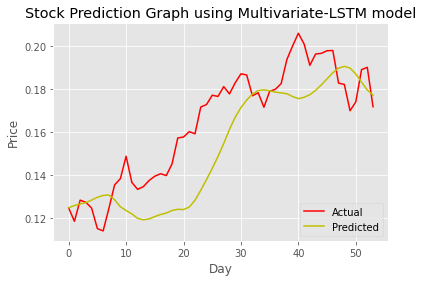

train_error  [0.06652462482452393, 0.04329930245876312, 0.030597524717450142, 0.014916455373167992, 0.009718907997012138, 0.007854441180825233, 0.010621379129588604, 0.009216615930199623, 0.00866405013948679, 0.008901149034500122, 0.007478686049580574, 0.006776624359190464, 0.007433578837662935, 0.006629173178225756, 0.005028578452765942, 0.004310570191591978, 0.0036389364395290613, 0.00290117459371686, 0.0030057679396122694, 0.0025747139006853104, 0.0023188311606645584, 0.002483916701748967, 0.0023903704714030027, 0.0028530273120850325, 0.0025253293570131063, 0.002615810837596655, 0.0025060090702027082, 0.002630312228575349, 0.002299942309036851, 0.0025019750464707613, 0.002575347665697336, 0.002892759395763278, 0.00242989556863904, 0.003448145231232047, 0.002639706712216139, 0.002947169588878751, 0.002810737118124962, 0.003211074974387884, 0.0026353357825428247, 0.003230731701478362, 0.0029801460914313793, 0.003385489108040929, 0.0034279131796211004, 0.0030726625118404627, 0.00321902

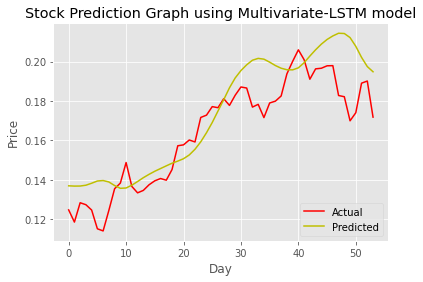

train_error  [0.06026981770992279, 0.0551115982234478, 0.03672046214342117, 0.013972335495054722, 0.022633960470557213, 0.01081205252557993, 0.008874400518834591, 0.009368295781314373, 0.008074883371591568, 0.008934780955314636, 0.008088947273790836, 0.007302002981305122, 0.005762710701674223, 0.004921100568026304, 0.004894060082733631, 0.0045605250634253025, 0.003935129847377539, 0.004105811007320881, 0.004804700147360563, 0.005152602214366198, 0.003920720890164375, 0.0045973132364451885, 0.004402372986078262, 0.0044373623095452785, 0.004896463826298714, 0.004071783274412155, 0.004647424444556236, 0.0054695880971848965, 0.004544520750641823, 0.004876437596976757, 0.00484365364536643, 0.005478719715029001, 0.005041522905230522, 0.00473952479660511, 0.004981030244380236, 0.004318696446716785, 0.00443313317373395, 0.003659605048596859, 0.003306617494672537, 0.003476672573015094, 0.0026511934120208025, 0.002947828732430935, 0.0031096229795366526, 0.0028168135322630405, 0.00325928861275315

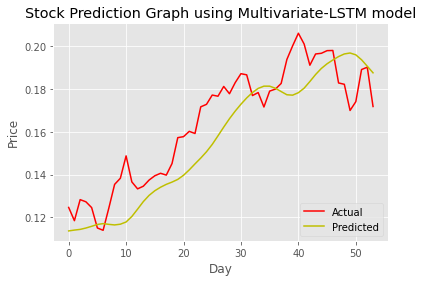

train_error  [0.07768487930297852, 0.06262391060590744, 0.045122820883989334, 0.051621612161397934, 0.06076083332300186, 0.029140422120690346, 0.03193173184990883, 0.03503205254673958, 0.03672628849744797, 0.03241046518087387, 0.020784955471754074, 0.019656453281641006, 0.010470021516084671, 0.008043832145631313, 0.006228077691048384, 0.0069887712597846985, 0.006571400910615921, 0.006518341600894928, 0.00776692433282733, 0.007391334045678377, 0.006564579904079437, 0.007188697811216116, 0.006299086846411228, 0.0064941043965518475, 0.005621973425149918, 0.005845413543283939, 0.006636303849518299, 0.006072145886719227, 0.006535572465509176, 0.005780403036624193, 0.004850022029131651, 0.0046526603400707245, 0.004290387034416199, 0.004453213419765234, 0.00387012236751616, 0.00377056747674942, 0.00319483014754951, 0.0031108378898352385, 0.003068921621888876, 0.0029831721913069487, 0.002852980513125658, 0.0027529397048056126, 0.0030590288806706667, 0.0026094105560332537, 0.002882136730477214,

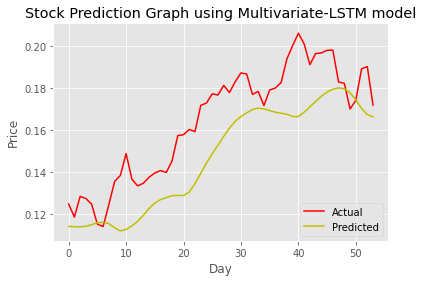

train_error  [0.0406905934214592, 0.04744568094611168, 0.0415242575109005, 0.02968977764248848, 0.03778843209147453, 0.023273635655641556, 0.023824291303753853, 0.014355764724314213, 0.016375528648495674, 0.014438883401453495, 0.014855312183499336, 0.013071907684206963, 0.011335616931319237, 0.012186226435005665, 0.010539203882217407, 0.010354637168347836, 0.008949069306254387, 0.008302055299282074, 0.007762734778225422, 0.006264240946620703, 0.00553709315136075, 0.005135920364409685, 0.005282882135361433, 0.004164074081927538, 0.0041211629286408424, 0.003909089602530003, 0.003450829302892089, 0.0033526408951729536, 0.0035461299121379852, 0.0031184395775198936, 0.0034277152735739946, 0.003159693442285061, 0.003812388749793172, 0.0029479560907930136, 0.0028832026291638613, 0.003102086717262864, 0.002942820079624653, 0.0029309915844351053, 0.0026936314534395933, 0.0031768176704645157, 0.0030669814441353083, 0.0027474917005747557, 0.003143037436529994, 0.002757529728114605, 0.003055821638

In [ ]:
results = list()
cross_val_results = list()
n_split = 5
X = train

for t in timesteps:
  for l in hl:
      for rate in lr:
          for batch in batch_size:
              for epochs in num_epochs:
                for loss in loss:
                  for a in activation:
                    
                    train_loss = pd.DataFrame()
                    val_loss = pd.DataFrame()
                    train_loss_value = 0
                    val_loss_value = 0
                
                    for train_index,test_index in KFold(n_split).split(X):
                      #print(train_index,test_index)
                      x_train = X[train_index]
                      x_test = X[test_index]
                      #y_train,y_test=Y[train_index],Y[test_index]
                      model,train_error,val_error = fit_model(x_train,x_test,t,l,rate,batch,epochs,loss,a)
                      train_loss['fold'] = train_error
                      val_loss['fold'] = val_error
                      mse, rmse, r2_value,true,predicted = evaluate_model(model,test,t)
                      #print("Split 1", fold_no)
                      print('MSE = {}'.format(mse))
                      print('RMSE = {}'.format(rmse))
                      print('R-Squared Score = {}'.format(r2_value))
                      
                      plot_data(true,predicted)
                      cross_val_results.append([mse,rmse,r2_value,0])
                      #model,train_error,val_error = fit_model(x_train,x_test,timesteps,hl,lr,batch_size,num_epochs)
                      print('train_error ',train_error)
                      #model,train_loss,val_loss = fit_model(train,val,t,l,rate,batch,epochs)
                      train_loss_value = train_loss_value + train_loss.iloc[-1]['fold']
                      val_loss_value = val_loss_value + val_loss.iloc[-1]['fold']
                
                    results.append([t,l,rate,batch,epochs,loss,a,train_loss_value/n_split,val_loss_value/n_split])
                    print(results)                  

pd.DataFrame(results,columns=['Timestep','Hidden_Layers','Learning_Rate','Batch_Size','epochs','Loss','Activation','Train_Loss','Val_Loss']).to_csv('Multivariate-LSTM_model_Timesteps_0107.csv')
pd.DataFrame(cross_val_results,columns=['mse','rmse','r2_value','0']).to_csv('Multivariate-LSTM_model_Mse_0107.csv')

In [ ]:
results

In [ ]:
cross_val_results

In [ ]:
timesteps = 50
hl = [60,55]
lr = 1e-3
batch = 64
epochs = 100
#optimizers = ['SGD', 'RMSprop', 'Adam']
loss = 'mean_squared_error'
activation = 'selu'

In [ ]:
X_train = []
Y_train = []
X_val = []
Y_val = []
  
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)
  
# Loop for val data
for i in range(timesteps,test.shape[0]):
    X_val.append(test[i-timesteps:i])
    Y_val.append(test[i][0])
X_val,Y_val = np.array(X_val),np.array(Y_val)
    
# Adding Layers to the model
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, activation = activation, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
# Adding LSTM layers and some Dropout regularisation
for i in range(len(hl)-1):        
  model.add(LSTM(hl[i], activation = activation,return_sequences = True))
  #model.add(Dropout(0.2))
model.add(LSTM(hl[-1],activation = activation))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= lr), loss = loss)
    
# Training the data
history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                        shuffle = False, callbacks=callbacks_list)
model.reset_states()
#model, history.history['loss'], history.history['val_loss']

In [ ]:
results = list()
cross_val_results = list()

mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)

print(f"length of prediction : {len(predicted)}")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
                      
plot_data(true,predicted)


In [ ]:
import matplotlib.pyplot as pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
print(history.history['loss'])

In [ ]:
print(history.history['val_loss'])

In [ ]:
model.save('DL_Project_LSTM_20220107')